In [1]:
from dask.distributed import Client
client = Client()

In [83]:
import matplotlib.pyplot as plt

In [2]:
import dask.dataframe as dd

def readCSV(file, debug=False):
    if debug: print('Reading ' + file)
    return dd.read_csv(file, parse_dates=['CHARTTIME', 'STORETIME'], dtype={'CGID': 'float64','ICUSTAY_ID': 'float64'})

In [3]:
path = './EVENTS_1000000.csv'
df = readCSV(path)

In [4]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249.0,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,15.00,15.00,L/min,0,0,NaN,NaN
1,789,36,165660,241249.0,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,100.00,100.00,NaN,0,0,NaN,NaN
2,790,36,165660,241249.0,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823.0,0.37,0.37,NaN,0,0,NaN,NaN
3,791,36,165660,241249.0,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,6.00,6.00,min,0,0,NaN,NaN
4,792,36,165660,241249.0,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,2.50,2.50,NaN,0,0,NaN,NaN


In [11]:
df.compute().describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CGID,VALUE,VALUENUM,WARNING,ERROR,RESULTSTATUS,STOPPED
count,9.999990e+05,999999.000000,999999.000000,999542.000000,999999.000000,847390.000000,999999.000000,999999.000000,999999.000000,999999.000000,0.0,0.0
mean,5.003201e+05,5800.489858,148498.552431,254446.497683,222180.309609,18182.896204,85.618958,85.618958,0.065634,0.001921,NaN,NaN
std,2.892129e+05,3503.306794,27689.259457,31045.418397,2488.229065,2288.817959,778.306520,778.306520,0.247641,0.043787,NaN,NaN
min,1.000000e+00,23.000000,100009.000000,200203.000000,220045.000000,14023.000000,-610.000000,-610.000000,0.000000,0.000000,NaN,NaN
25%,2.500005e+05,2636.000000,128932.000000,225777.000000,220180.000000,16037.000000,17.000000,17.000000,0.000000,0.000000,NaN,NaN
50%,5.000000e+05,5885.000000,142471.000000,256064.000000,220277.000000,18462.000000,56.000000,56.000000,0.000000,0.000000,NaN,NaN
75%,7.499995e+05,8799.000000,172420.000000,284784.000000,224684.000000,20652.000000,97.000000,97.000000,0.000000,0.000000,NaN,NaN
max,1.058971e+06,10694.000000,199622.000000,299972.000000,228377.000000,21545.000000,598185.120000,598185.120000,1.000000,1.000000,NaN,NaN


### Histogram of values per item
- For a given item, i.e., `ITEMID`, get its respective rows
- Plot its items, i.e., `VALUENUM` entries
- A scatter plot was used as it represents more appropriately the data presented

In [132]:
def item_hist(df, item):
    df_item = df[['ITEMID', 'CHARTTIME', 'VALUENUM']].query(f'ITEMID == {item}')
    df_item.compute().plot(x='CHARTTIME', y='VALUENUM', style='.')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Scatter of values for ITEMID {item}')

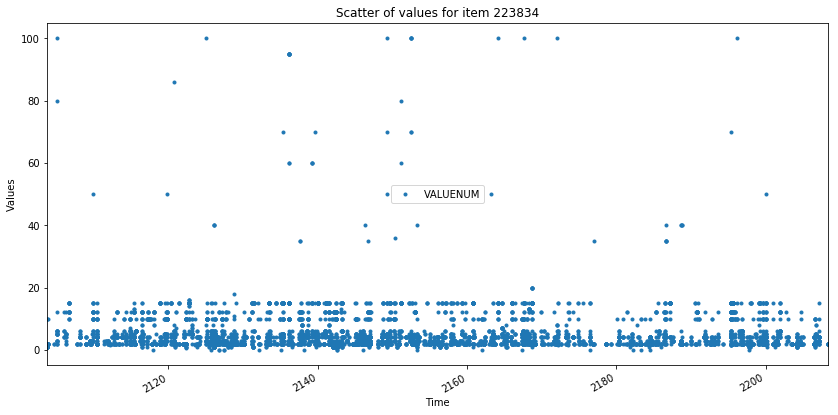

In [131]:
item_hist(df, item=223834)

### Histogram of values per patient

- For each patient, i.e., `SUBJECT_ID`, get its hospital admissions, i.e., `HADM_ID`
- For each hospital admission, plot the entries for each item, i.e., `VALUENUM` for each `ITEMID`
- A scatter plot was used as it represents more appropriately the data presented

In [128]:
# Get histogram of values per patient
def patient_hist(df, patient):
    
    
    df[['SUBJECT_ID', 'ITEMID', 'VALUENUM', 'HADM_ID']]\
                .query(f'SUBJECT_ID == {patient}')\
                .compute()\
                .groupby('HADM_ID')['ITEMID', 'VALUENUM']\
                .plot(x='ITEMID', y='VALUENUM', kind='scatter')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Items')
    ax.set_ylabel('Values')
    ax.set_title('')

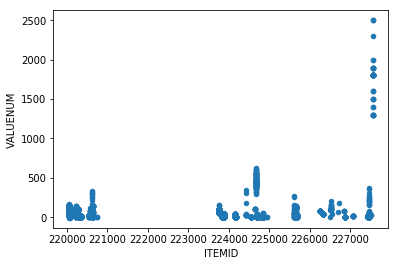

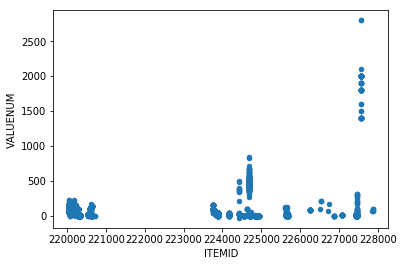

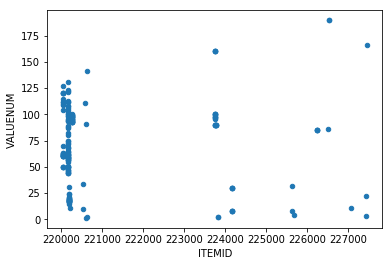

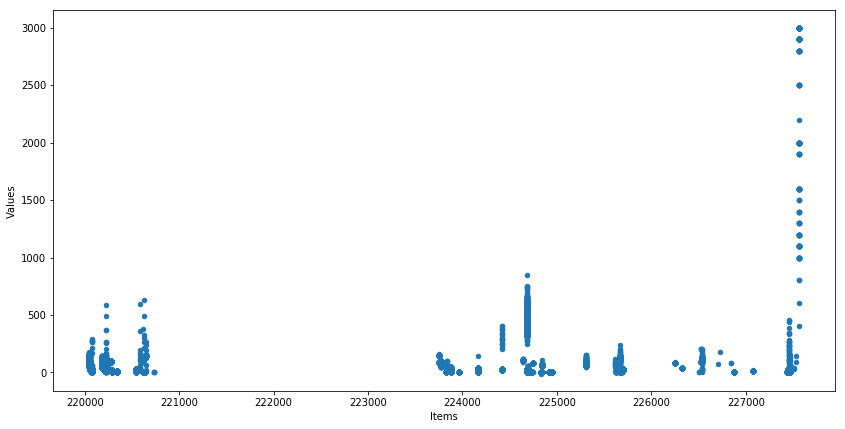

In [129]:
patient_hist(df, patient=2090)

In [126]:
# Get histogram of frequency per item
def item_hist(df):
    df[['ITEMID', 'VALUENUM']]\
                .compute()\
                .groupby('ITEMID').count()\
                .hist()
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Items')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency per item')

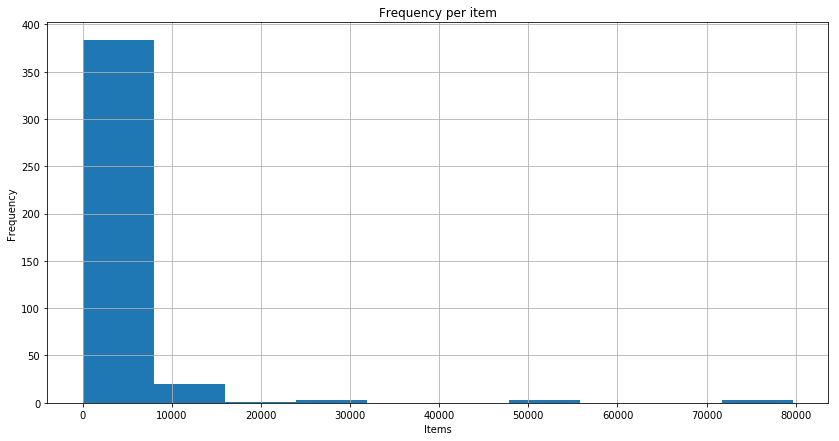

In [127]:
item_hist(df)

### Scatter of items's values over time
- For a given Intensive Care Unit instance, i.e., `ICUSTAY_ID`, get its entries
- Plot its items' values, i.e., `VALUENUM` entries, through time

In [124]:
def icu_hist(df, icu):
    df_icu = df[['SUBJECT_ID', 'VALUENUM', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID']]\
                .query(f'ICUSTAY_ID == {icu}')\
                .compute()\
                .plot(x='CHARTTIME', y='VALUENUM', style='o')
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title('Items\' values over time')

['0.49411764705882355', '0.9215686274509803', '0.6392156862745098', '0.8823529411764706', '0.8862745098039215', '0.10588235294117647', '0.1568627450980392', '0.1803921568627451', '0.23529411764705882', '0.27450980392156865']


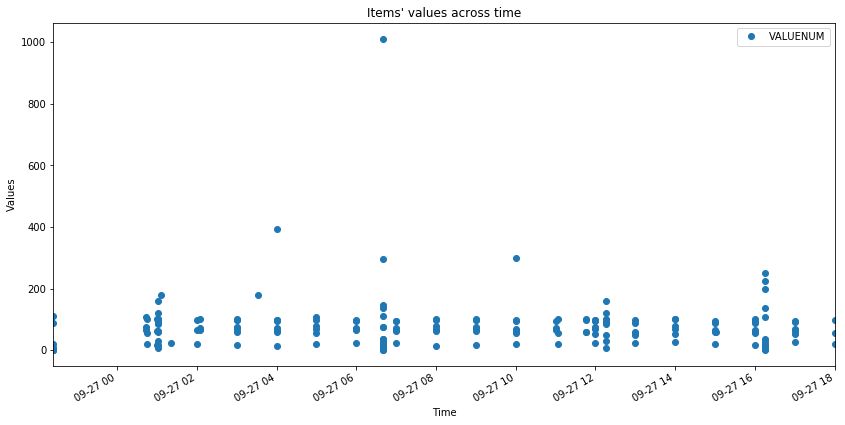

In [125]:
icu_hist(df, 261926)